# Requirements

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl
import yfinance as yf
from collections import defaultdict
from datetime import datetime

# Mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Using Yahoo Finance Data
If one wants to fetch data from Yahoo finance and test strtedgy they need to specify the required symbol as well as required end and start time

In [ ]:
def fetch_data(symbol, starttime, endtime):
  symbol = symbol
  # Specify the start and end times
  start = starttime
  end = endtime

  #Download intraday
  data = yf.download(symbol, start=start, end=end)
  data.rename(columns = {'Date':'datetime'}, inplace = True)
  data.rename(columns = {'Open':'open'}, inplace = True)
  data.rename(columns = {'Close':'close'}, inplace = True)
  data.rename(columns = {'Low':'low'}, inplace = True)
  data.rename(columns = {'High':'high'}, inplace = True)
  data.rename(columns = {'Volume':'volume'}, inplace = True)
  data.drop('Adj Close',axis=1)

  data.reset_index(inplace = True)
  data.rename(columns = {'Date':'datetime'}, inplace = True)

  return data

# Using custom data
One can use custom data either by mounting google drive or uploading the required file

In [ ]:
def create_dataset(path):
  df = pd.read_csv(path)
  df.set_index('datetime', inplace=True)
  if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

  first_value = lambda x: x.iloc[0] if not x.empty else None

  last_value = lambda x: x.iloc[-1] if not x.empty else None

  agg_dict = {
              'open': first_value,
              'high': 'max',
              'low': 'min',
              'close': last_value,
              'volume': 'sum'
            }

  df_resampled = df.resample('1D').agg(agg_dict)

  df_resampled.reset_index(inplace=True)

  return df_resampled

# Calculations and Testing

### ATR Calculation

In [ ]:
# Calculate the ATR indicator
def atr(DF,n):
    df=DF.copy()
    df['High-Low']=abs(df['high']-df['low'])
    df['High-PreviousClose']=abs(df['high']-df['close'].shift(1))
    df['Low-PreviousClose']=abs(df['low']-df["close"].shift(1))
    df['TrueRange']=df[['High-Low','High-PreviousClose','Low-PreviousClose']].max(axis=1,skipna=False)
    df['ATR']=df['TrueRange'].ewm(com=n,min_periods=n).mean()
    return df['ATR']


### ADX Calculation

In [ ]:
#calculate ADX
def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()

    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth


### Preprocessing on the data
Precomputing the required columns of Heikanshi Candles, RSI and ADX for further calcultations

In [ ]:
def process_data(df, atr_period):
  # Calculate the Heikin Ashi candles
  df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
  df['HA_Open'] = (df['open'].shift(1) + df['close'].shift(1)) / 2
  df['HA_High'] = df[['high', 'low', 'HA_Open', 'HA_Close']].max(axis=1)
  df['HA_Low'] = df[['high', 'low', 'HA_Open', 'HA_Close']].min(axis=1)


  # Initialize the position and signal columns
  df['Position'] = 0
  df['signals'] = 0

  #caclulate the required indicators
  df['adx'] = pd.DataFrame(get_adx(df['high'], df['low'], df['close'], 15)[2]).rename(columns = {0:'adx'})
  df['adxl'] = pd.DataFrame(get_adx(df['high'], df['low'], df['close'], 250)[2])
  df['ATR']=atr(df,atr_period)
  df['DailyReturns'] = df['close'].pct_change()
  df['WeeklyReturns']=df['DailyReturns'].rolling(5).sum()
  df['CumulativeReturns'] = (1 + df['DailyReturns']).cumprod()


  return df

### Postprocessing on data

In [ ]:
def post_process(df):

  #calculating strategy returns
  df['StrategyReturns'] = df['Position'] * df['DailyReturns']


  #calculating no of trades and applying transaction costs
  trades=0
  for i in range(1, len(df)):
      if(df.loc[i,'signals']!=0):
          trades+=abs(df.loc[i,'signals'])
          df.loc[i,'StrategyReturns']-=0.0005*abs(df.loc[i,'signals'])

  #calculating Cumulative returns
  df['CumulativeStrategyReturns'] = (1 + df['StrategyReturns']).cumprod()
  df['StrategyReturns'][0]=1

  #calculation of sharpe and drawdown
  df['MDD']=((df['StrategyReturns'].cumsum().cummax()-df['StrategyReturns'].cumsum())/df['StrategyReturns'].cumsum().cummax())*100
  average_strategy_return = df['StrategyReturns'].mean()
  std_dev_strategy_return = df['StrategyReturns'].std()

  return df, trades, average_strategy_return, std_dev_strategy_return

### Main Strategy

In [ ]:
def HeikenAshi(df, atr_multiplier=4):
  for i in range(1, len(df)-1):
    # Get the previous and current values of the indicators and candle
    prev_ha_close = df.loc[i-1, 'HA_Close']
    curr_ha_close = df.loc[i, 'HA_Close']
    prev_ha_open = df.loc[i-1, 'HA_Open']
    curr_ha_open = df.loc[i, 'HA_Open']
    curr_atr = df.loc[i, 'ATR']


    #long condition
    if (prev_ha_close > prev_ha_open and curr_ha_close > curr_ha_open  and df['adx'][i]<25 and df['adxl'][i]<50) and df['Position'][i]!=1:
          # Enter a long position and set the signal to 1
          df.loc[i+1, 'Position'] = 1
          df.loc[i, 'signals'] = df.loc[i+1, 'Position']-df.loc[i,'Position']
          # Set the initial stop loss to the current low minus the ATR multiplied by the multiplier
          stop_loss = df.loc[i, 'high'] - curr_atr * (atr_multiplier+1)



    #short condition
    elif (prev_ha_close > prev_ha_open and curr_ha_close < curr_ha_open and df['adx'][i]<25 and df['adxl'][i]<50) and df['Position'][i]!=-1 :
          # Enter a short position and set the signal to -1
          df.loc[i+1, 'Position'] = -1
          df.loc[i, 'signals'] = df.loc[i+1, 'Position']-df.loc[i,'Position']
          # Set the initial stop loss to the current high plus the ATR multiplied by the multiplier
          stop_loss = df.loc[i, 'low'] + curr_atr * (atr_multiplier-1)



    #secondary long condition
    elif( df['adx'][i]>60 and df['Position'][i]!=1  and df['WeeklyReturns'][i]<0 ):
          df.loc[i+1, 'Position'] = 1
          df.loc[i, 'signals'] = df.loc[i+1, 'Position']-df.loc[i,'Position']
          # Set the initial stop loss to the current low minus the ATR multiplied by the multiplier
          stop_loss = df.loc[i, 'high'] - curr_atr * (atr_multiplier+1)



    #secondary short condition
    elif(df['adx'][i]>60 and df['Position'][i]!=-1 and df['WeeklyReturns'][i]>0):
          # Enter a short position and set the signal to -1
          df.loc[i+1, 'Position'] = -1
          df.loc[i, 'signals'] = df.loc[i+1, 'Position']-df.loc[i,'Position']
          # Set the initial stop loss to the current high plus the ATR multiplied by the multiplier
          stop_loss = df.loc[i, 'low'] + curr_atr * (atr_multiplier-1)


    #stoploss implementation
    else:
          # If the current position is long
          if df.loc[i, 'Position'] == 1:
              # Carry over the position
              df.loc[i+1, 'Position'] = 1
              # Check if the current low is below the stop loss
              if df.loc[i, 'low'] < stop_loss :
                  # Exit the position and set the signal to -1
                  df.loc[i+1, 'Position'] = 0
                  df.loc[i, 'signals'] = -1

              # Otherwise, update the stop loss to the maximum of the previous stop loss and the current high minus the ATR multiplied by the multiplier
              else:
                  stop_loss = max(stop_loss, df.loc[i, 'high'] - curr_atr * (atr_multiplier+1))
          # If the current position is short
          elif df.loc[i, 'Position'] == -1:
              # Carry over the position
              df.loc[i+1, 'Position'] = -1
              # Check if the current high is above the stop loss
              if df.loc[i, 'high'] > stop_loss :
                  # Exit the position and set the signal to 1
                  df.loc[i+1, 'Position'] = 0
                  df.loc[i, 'signals'] = 1

              # Otherwise, update the stop loss to the minimum of the previous stop loss and the current low plus the ATR multiplied by the multiplier
              else:
                  stop_loss = min(stop_loss, df.loc[i, 'low'] + curr_atr * (atr_multiplier-1))

          # If the current position is neutral
          else:
              # Carry over the position
              df.loc[i+1, 'Position'] = 0

  return df

### Plotting Results

In [ ]:
def plot_results(df, trades, average_strategy_return, std_dev_strategy_return):
  plt.figure(figsize=(12, 10))
  plt.subplot(3, 1, 1)
  plt.plot(df['CumulativeReturns'], label='Buy and Hold')
  plt.plot(df['StrategyReturns'].cumsum(), label='HA+2ADX : static')
  plt.legend()
  plt.title('Cumulative Returns')

  plt.subplot(3, 1, 3)
  plt.plot(df['CumulativeStrategyReturns'], label='HA+2ADX:compound')
  plt.plot(df['StrategyReturns'].cumsum(), label='HA+2ADX :static')
  plt.legend()
  plt.title('Strategy Returns')


  plt.subplot(3, 1, 2)

  plt.plot(df['MDD'], label='Drawdown')
  plt.legend()
  plt.title('Drawdown Analysis')

  plt.show()
  max_ddn=df['MDD'].max()
  sharpe_ratio=(365*average_strategy_return)/(np.sqrt(365)*std_dev_strategy_return)
  print(f'Sharpe Ratio: {sharpe_ratio:.4f}')
  print(f'No of trades: {trades:.4f}')
  print(f'Max Drawdown: {max_ddn:.4f} %')

## MAIN RUN

[*********************100%%**********************]  1 of 1 completed


<ipython-input-160-19b2fe66bada>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StrategyReturns'][0]=1


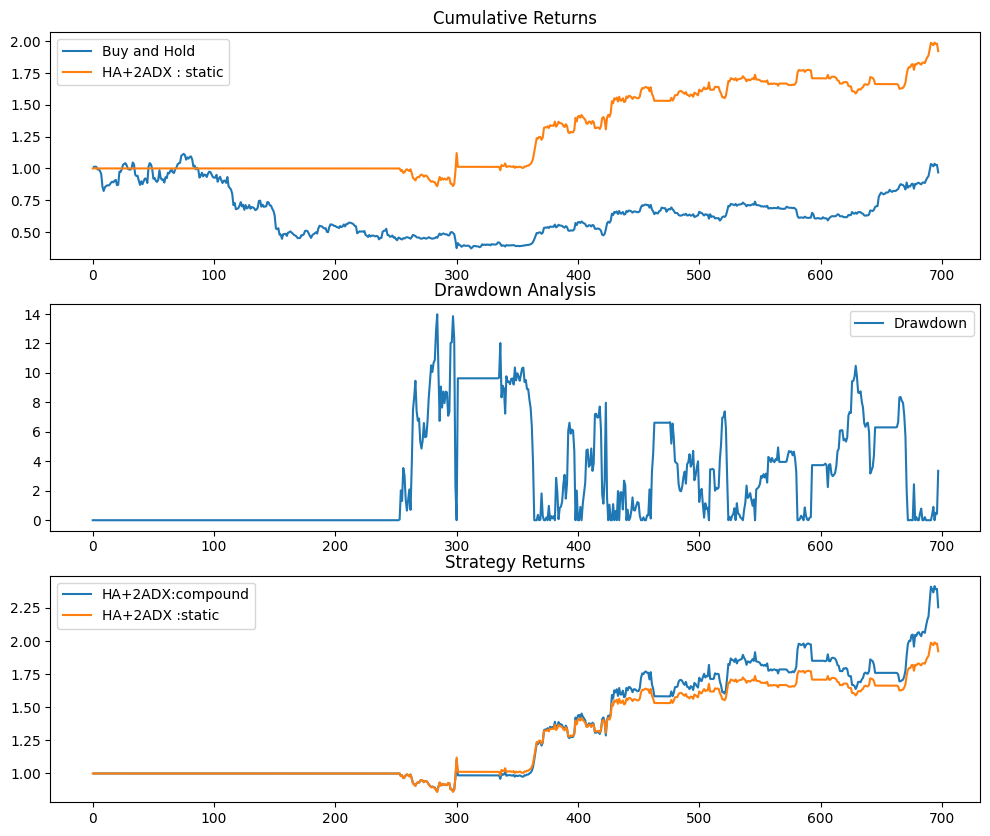

Sharpe Ratio: 1.2589
No of trades: 111.0000
Max Drawdown: 13.9745 %


In [ ]:
#If want to use your custom data specify the path here
#df = create_dataset('/content/drive/MyDrive/btcusdt_30m.csv')

#If want to use yahoo finance data
symbol = "BTC-USD"
# Specify the intraday start and end times
start = datetime(2022, 1, 13, 0, 0, 0)
end = datetime(2023, 12, 12, 0, 0, 0)

n=10

df = fetch_data(symbol, start, end)
df = process_data(df, n)

atr_multiplier=3
stoploss = 0

df = HeikenAshi(df, atr_multiplier)

df, trades, average_strategy_return, std_dev_strategy_return = post_process(df)

plot_results(df, trades, average_strategy_return, std_dev_strategy_return)

# CREATING LOGS

Specify the 3m interval data file

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/btcusdt_3m.csv')

In [ ]:

data['signals'] = 0
df.rename(columns = {'Date':'datetime'}, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])
data['datetime'] = pd.to_datetime(data['datetime'])

data.set_index('datetime', inplace=True)

In [ ]:
from datetime import datetime, timedelta
import pandas as pd

for i in range(0, len(df)):
    if abs(df['signals'][i]) == 2:
        new_datetime = df['datetime'][i] + timedelta(minutes=57) + timedelta(hours=23)
        data.at[new_datetime, 'signals'] = df['signals'][i]/2
        data.at[new_datetime + timedelta(minutes=3), 'signals'] = df['signals'][i]/2
    elif abs(df['signals'][i]) == 1:
        new_datetime = df['datetime'][i] + timedelta(minutes=57) + timedelta(hours=23)
        data.at[new_datetime, 'signals'] = df['signals'][i]

data.reset_index(inplace=True)

In [ ]:
data

,datetime,open,high,low,close,volume,signals
0,2018-01-01 05:30:00,13715.65,13715.65,13666.11,13680.00,6.303815,0.0
1,2018-01-01 05:33:00,13679.98,13679.98,13554.44,13568.00,33.709206,0.0
2,2018-01-01 05:36:00,13568.00,13575.00,13501.01,13575.00,29.645987,0.0
3,2018-01-01 05:39:00,13539.99,13575.00,13400.01,13515.26,30.696039,0.0
4,2018-01-01 05:42:00,13515.26,13568.66,13473.47,13556.15,23.260966,0.0
...,...,...,...,...,...,...,...
704003,2023-11-15 00:00:00,NaN,NaN,NaN,NaN,NaN,1.0
704004,2023-11-15 23:57:00,NaN,NaN,NaN,NaN,NaN,-1.0
704005,2023-11-16 00:00:00,NaN,NaN,NaN,NaN,NaN,-1.0
704006,2023-11-16 23:57:00,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
print(len(data[data['signals']!=0]))

111


In [ ]:
data.to_csv('output_for_HA+2ADX.csv', index=True)